# Use Case: Mode Dropping & Mode Collapse

**Mode collapse** and **mode dropping** are two commonly faced problems in machine learning related to a decrease in output diversity as compared to the input/training data. 

- **Mode dropping** is when a machine learning algorithm "drops" a category or distinct cluster of data ("mode") in its output. For example, we would consider a model trained to generate images of animals that never outputs a image of a bird to suffer from mode dropping.

- **Mode collapse** is an extreme case of mode dropping, when all but a few modes have been dropped. For example, a model trained to generate images of animals that only ever outputs images of dogs would suffer from mode collapse.

### Diversipy as a mode dropping/collapse detection tool.

Both can be detected using `Diversipy` by computing MagDiff between the output data and the input data (reference dataset). Higher MagDiffs would indicate greater likelihood of mode dropping and/or collapse. Additionally, MagDiff is shown to detect mode dropping & collapse earlier than existing ML quality metrics.

### Demo

We include the following demo to show how Diversipy can be used to detect mode collapse, with the hope that it provides a helpful and explanatory example.

In [1]:
# Import statements
from matplotlib.animation import FuncAnimation
from magnipy import Magnipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tutorial_data import *

We begin by creating our toy dataset by sampling from three Gaussians to create **three distinct modes** (clusters).

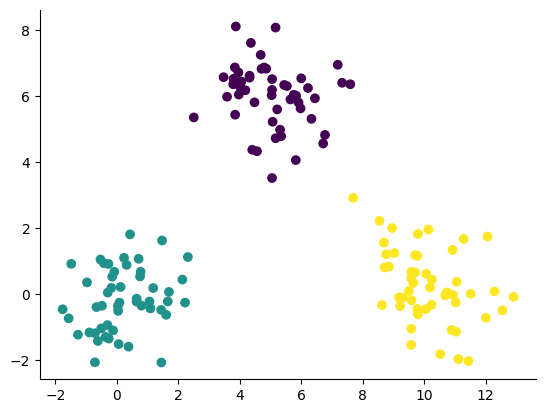

In [2]:
# Setting hyperparameters
np.random.seed(4)
mean1 = [5, 6]
cov1 = np.eye(2) * 1.1
size = 50

# Sampling data
points1 = sample_points_gaussian(mean1, cov1, size)
points2 = sample_points_gaussian([0, 0], cov1, size)
points3 = sample_points_gaussian([10, 0], cov1, size)
make_blobs = np.concatenate([points1, points2, points3], axis=0)
x = make_blobs[:, 0]
y = make_blobs[:, 1]

# Plot
colors = np.array(np.concatenate([np.zeros(size), np.ones(size), np.ones(size) * 2]))
plt.scatter(x, y, c=colors)
sns.despine()

Next, **we simulate mode dropping** by iteratively removing 1 point from each of the 'green' and 'yellow' modes and adding two new points sampled from same Gaussian that made the purple mode. This effectively replaces two points from other modes with two points in the purple mode, i.e. "dropping" the green and yellow modes. As you would expect, as more points are replaced (i.e. more mode dropping occurs), the diversity of the replacement dataset declines.

At each iteration of this replacement process, we compute the **MagDiff between our original dataset and the latest iteration of our replacement dataset.**

Below, we plot the -MagDiff as a function of the number of points that have been dropped/replaced.

_Aside: Why -MagDiff?_
MagDiff, as the difference between two areas, is always positive. However, -MagDiff here captures the idea that the diversity of replacement dataset is declining.

In [ ]:
simulate_mode_dropping(is_normalized=False)

A full animation of the process is rendered here:

![Mode Dropping Simulation](assets/mode_dropping.gif)

We can also visualize this process by plotting the normalized MagDiff - that is, the MagDiff between the original dataset and the replacement dataset divided by the MagArea of the original dataset.

Recall that MagDiff is the difference in the diversity of the original dataset (a constant) and the replacement dataset (steadily decreasing), and thus grows over time. Normalizing simply changes the scale of the y-axis.

MovieWriter ffmpeg unavailable; using Pillow instead.


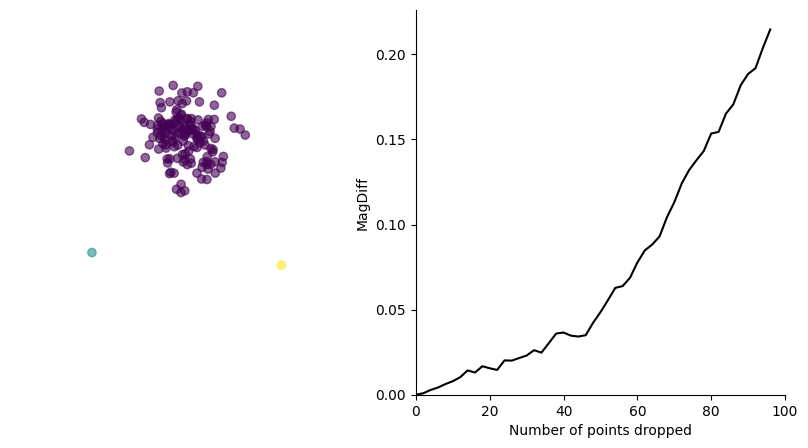

In [3]:
simulate_mode_dropping(is_normalized=True)

A full animation of the process is rendered here:

![Mode Dropping Simulation (Normalized)](assets/mode_dropping_normalised.gif)

MagDiff can thus be a helpful tool for detecting mode dropping and mode collapse in ML, even outperforming other common ML metrics. For further discussion of this use of MagDiff, see [Metric Space Magnitude for Evaluating the Diversity of Latent Representations](https://arxiv.org/abs/2311.16054).